In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from darts import TimeSeries
from darts.models.forecasting.random_forest import RandomForest
from darts.models.forecasting.xgboost import XGBModel
from darts.metrics import rmse

from xgboost import XGBRegressor
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import kaleido
import plotly.io as pio
import scipy.stats as stats
import tensorflow as tf
from xgboost import DMatrix
import shap

In [2]:
plot_folder = '/Users/eddie/cs163/src/Plots'
data_folder = '/Users/eddie/cs163/src/Data'
pio.renderers.default = 'png'

def replace_with_underscore(x):
    return x.replace(' ', '_')
    

In [3]:
df = pd.read_csv('/Users/eddie/cs163/src/Data/final.csv', index_col=['DATE'], parse_dates=['DATE'], )
df = df.asfreq('MS')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 237 entries, 2005-01-01 to 2024-09-01
Freq: MS
Data columns (total 18 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Frozen Food Manufacturing PPI                    237 non-null    float64
 1   Dried and dehydrated Food Manufacturing PPI      237 non-null    float64
 2   Seafood Production and Packaging PPI             237 non-null    float64
 3   Snack Food Manufacturing PPI                     237 non-null    float64
 4   Perishable Food Manufacturing PPI                237 non-null    float64
 5   Food and Beverages Retailers PPI                 237 non-null    float64
 6   Food and Beverages CPI (target)                  237 non-null    float64
 7   Civilian workers Total compensation              237 non-null    float64
 8   Private industry workers Total compensation      237 non-null    float64
 9   Stat

In [4]:
Y = df.iloc[:, 6]
X = df[[c for c in df.columns if c not in ['Food and Beverages CPI (target)']]]

### KNN Imputation for Fish Food and Horticulture

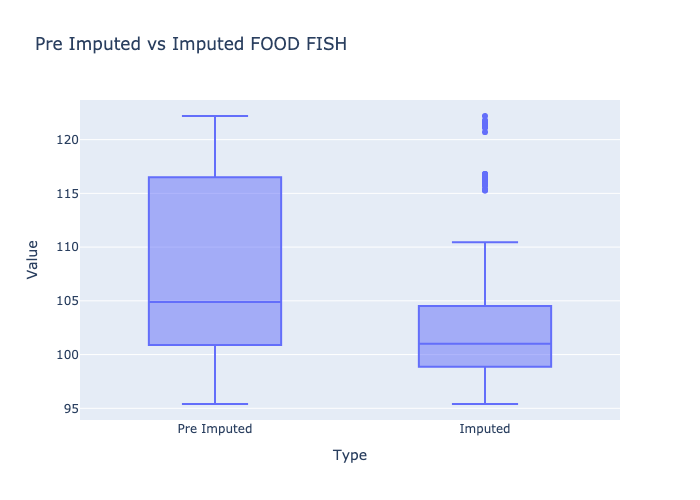

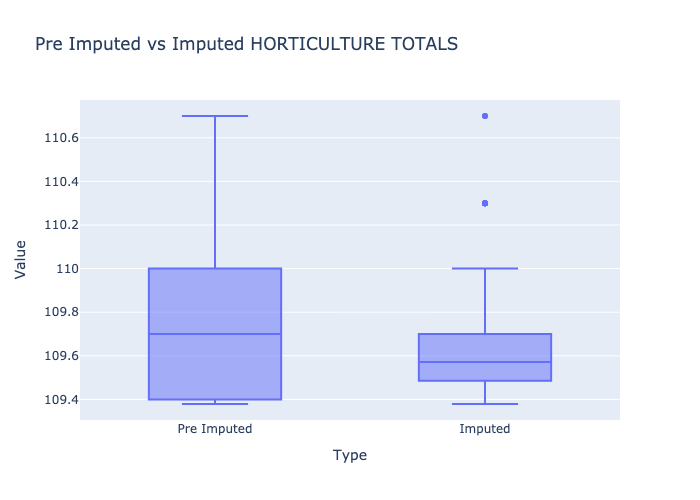

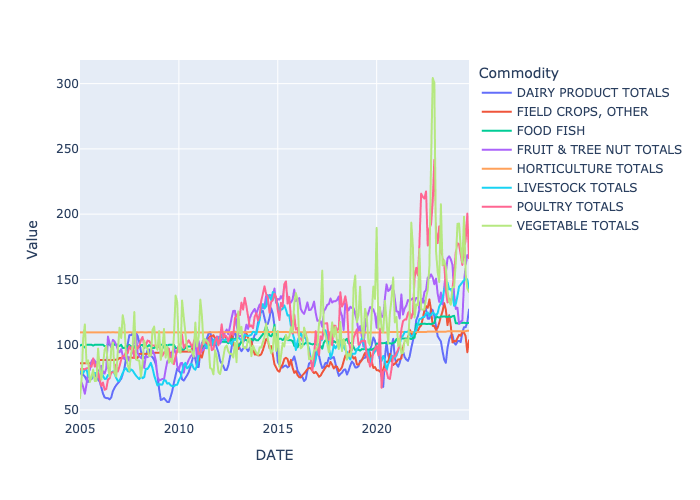

In [5]:
imputer = KNNImputer(n_neighbors=7)
# scaler = StandardScaler()
RPI_df = X.iloc[:,9:]
# RPI_df = pd.DataFrame(scaler.fit_transform(RPI_df), columns=RPI_df.columns, index=X.index)
RPI_df_imputed = pd.DataFrame(imputer.fit_transform(RPI_df), columns=RPI_df.columns, index=X.index)

for column in ['FOOD FISH', 'HORTICULTURE TOTALS']:
    data = pd.DataFrame({
        'Pre Imputed': RPI_df[column], 
        'Imputed': RPI_df_imputed[column]
    }, index=X.index)
    data_melted = data.melt(var_name='Type', value_name='Value', ignore_index=False)
    fig = px.box(data_melted, title='Pre Imputed vs Imputed ' + column, x = 'Type', y = 'Value')
    fig.write_image(os.path.join(plot_folder,'KNN_Imputed_boxplot_for_' + replace_with_underscore(column) + '.png'), width=1280, height=640)
    fig.show()
    
RPI_df_imputed_melted = RPI_df_imputed.melt(value_name='Value', var_name='Commodity', ignore_index=False)
# RPI_df_imputed_melted = RPI_df_imputed_melted[RPI_df_imputed_melted['Commodity'].isin(['FOOD FISH', 'HORTICULTURE TOTALS'])]
fig = px.line(RPI_df_imputed_melted, x=RPI_df_imputed_melted.index, y='Value', color='Commodity')
fig.write_image(os.path.join(plot_folder,'Imputed_RPI_timeseries.png'), width=1280, height=640)
fig.show()

After the imputation, the data for FOOD FISH and HORTICULTURE appear to maintain the normal distribution but have new outliers. However, based on the timeseries line plot with other commodities RPI, the outliers are reasonable because other indices also have strong outliers at these periods. So, we can use the imputed data for further analysis.

In [6]:
# Update newly imputed values
X.update(RPI_df_imputed)
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 237 entries, 2005-01-01 to 2024-09-01
Freq: MS
Data columns (total 17 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Frozen Food Manufacturing PPI                    237 non-null    float64
 1   Dried and dehydrated Food Manufacturing PPI      237 non-null    float64
 2   Seafood Production and Packaging PPI             237 non-null    float64
 3   Snack Food Manufacturing PPI                     237 non-null    float64
 4   Perishable Food Manufacturing PPI                237 non-null    float64
 5   Food and Beverages Retailers PPI                 237 non-null    float64
 6   Civilian workers Total compensation              237 non-null    float64
 7   Private industry workers Total compensation      237 non-null    float64
 8   State and government workers Total compensation  237 non-null    float64
 9   DAIR

#### Consumer Expenditures Imputation

Since CE data is 2 months behind others, we will also use KNN Imputation to fill the missing value for them. Notes that this is only 2/236 so it should not affect the distribution.

In [7]:
imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 237 entries, 2005-01-01 to 2024-09-01
Freq: MS
Data columns (total 17 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Frozen Food Manufacturing PPI                    237 non-null    float64
 1   Dried and dehydrated Food Manufacturing PPI      237 non-null    float64
 2   Seafood Production and Packaging PPI             237 non-null    float64
 3   Snack Food Manufacturing PPI                     237 non-null    float64
 4   Perishable Food Manufacturing PPI                237 non-null    float64
 5   Food and Beverages Retailers PPI                 237 non-null    float64
 6   Civilian workers Total compensation              237 non-null    float64
 7   Private industry workers Total compensation      237 non-null    float64
 8   State and government workers Total compensation  237 non-null    float64
 9   DAIR

## Effect to CPI by RPI Commodity/ CE Worker segment/ PPI Industry using ARIMA with eXogenous variables (ARIMAX)

In [8]:
RPI_df = X.iloc[:, 9:].copy()
CE_df = X.iloc[:, 6:9].copy()
PPI_df = X.iloc[:, :6].copy()
category = [RPI_df, CE_df, PPI_df]

### Assumption check

#### Stationary of CPI

As we saw in the EDA time series plot of CPI, it is not stationary. So, we will use differencing and use Augmented Dick-Fuller test to determine the level of differencing needed for ARIMAX. Let the threshold be 0.05, our null hypothesis is the time-series has a unit root, which is non-stationary. 

In [9]:
adf_test = adfuller(Y)
print(f'ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}')

ADF Statistic: 0.7510415884815688, p-value: 0.990803340000276


Originally, p-value is 0.99 > 0.05. So, we cannot reject the null hypothesis yet and transformation is needed. We will try differencing 1 time.

In [10]:
def differencing(X, d):
    X_new = X.values
    for i in range(d):
        X_tmp = np.array(np.zeros(len(X)))
        for index in range(1, len(X)):
            X_tmp[index] = X_new[index] - X_new[index - 1]
        X_new = X_tmp
    
    return pd.Series(X_new, index=X.index)

for d in range(4):
    adf_test = adfuller(differencing(Y, d))
    print(f'Differencing level {d}: ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}')

Differencing level 0: ADF Statistic: 0.7510415884815688, p-value: 0.990803340000276
Differencing level 1: ADF Statistic: -3.1170512852301586, p-value: 0.02531678230732434
Differencing level 2: ADF Statistic: -12.539410345811296, p-value: 2.3324687638264017e-23
Differencing level 3: ADF Statistic: -7.68118208100506, p-value: 1.502483729131234e-11


So with 1 time differencing, CPI time-series is already stationary, so we will go with ``d = 1``

## Seasonality check

In [11]:
diff_y = Y.diff().dropna()

In [12]:
df_diff_seasonal_diff = np.diff(diff_y, n=12)     
 
ad_fuller_result = adfuller(df_diff_seasonal_diff)
 
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -17.466939444479586
p-value: 4.5648190456964396e-30


The 2 values that are 12 months apart are seasonal using seasonal differencing of degree 1

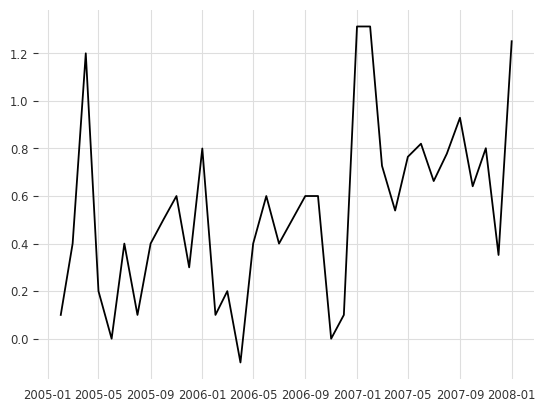

In [13]:
plt.plot(diff_y[:36])

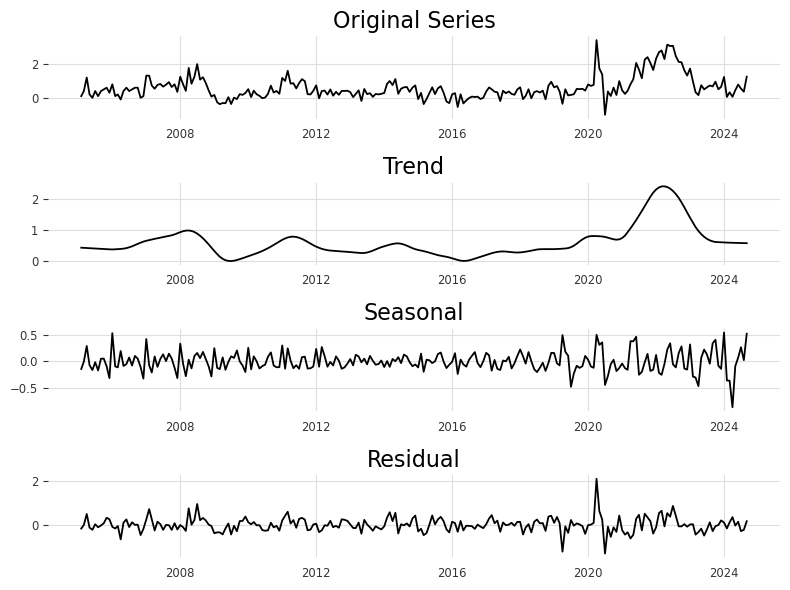

In [14]:
decomposition = STL(diff_y)
result = decomposition.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(diff_y)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(plot_folder, 'Seasonality_decomposition.png'))

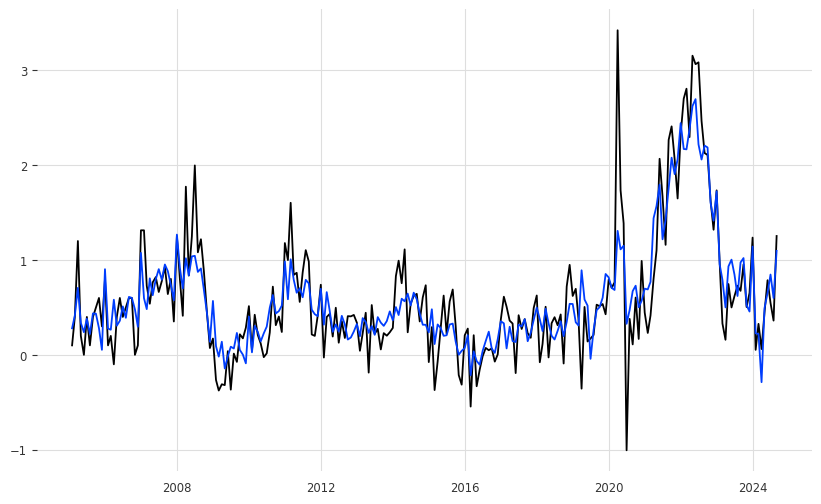

In [15]:
prediction = seasonal + trend
plt.figure(figsize=(10, 6))
plt.plot(diff_y)
plt.plot(prediction)
plt.savefig(os.path.join(plot_folder, 'SLT_prediction.png'))

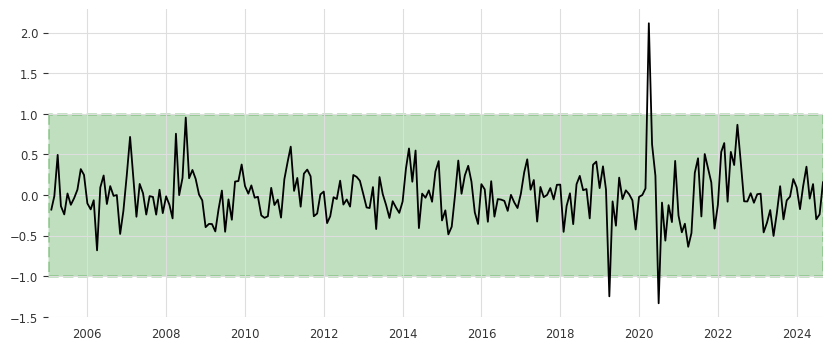

In [16]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2005,1,1), datetime(2024,9,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2005,1,1), datetime(2024,9,1))

plt.savefig(os.path.join(plot_folder, 'Anamolies_detection.png'))

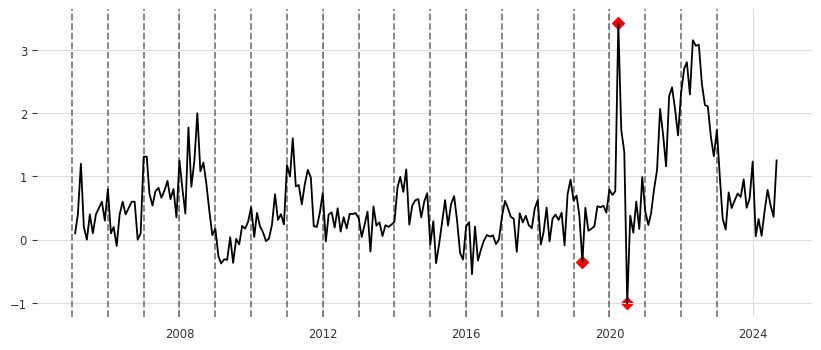

In [17]:
anomalies = diff_y[(resid < lower) | (resid > upper)]

plt.figure(figsize=(10,4))
plt.plot(diff_y)
for year in range(2005,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies.values, color='r', marker='D')
plt.savefig(os.path.join(plot_folder, 'Anamolies_points.png'))

### AR order and MA order

We will perform ACF and PACF to determine the Autoregressive term and Moving Average term.

                                      SARIMAX Results                                      
Dep. Variable:     Food and Beverages CPI (target)   No. Observations:                  231
Model:                              ARIMA(1, 1, 4)   Log Likelihood                -143.997
Date:                             Sun, 03 Nov 2024   AIC                            299.994
Time:                                     22:07:34   BIC                            320.622
Sample:                                 01-01-2005   HQIC                           308.315
                                      - 03-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9500      0.027     35.011      0.000       0.897       1.003
ma.L1         -0.4241      

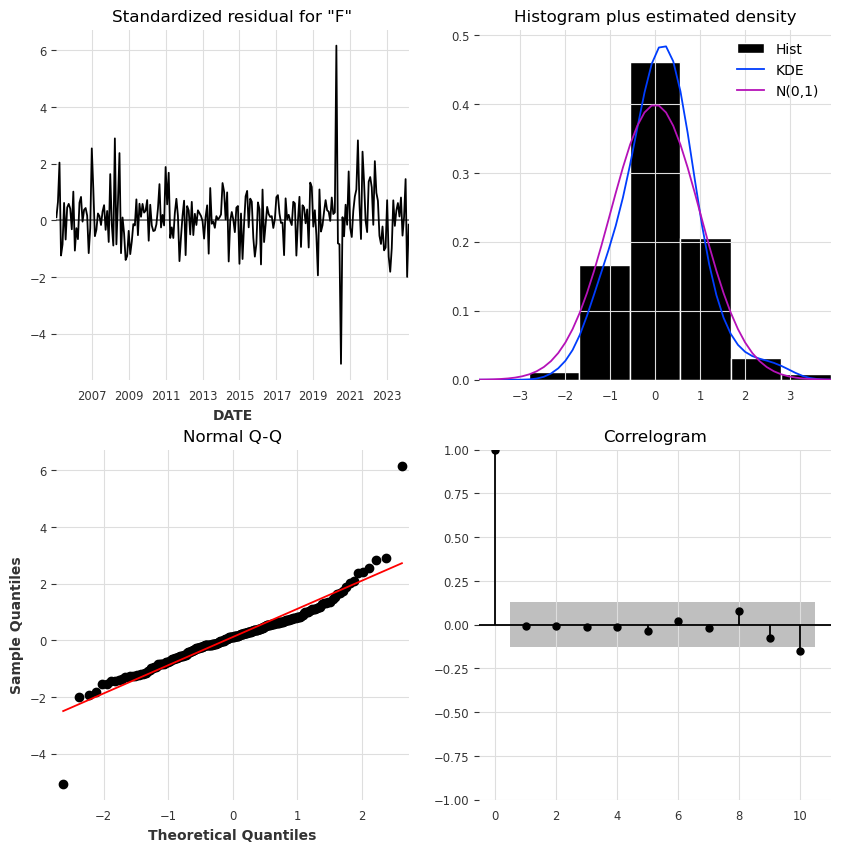

In [23]:
ARIMA_y_train = Y.iloc[:-6]
ARIMA_y_test = Y.iloc[-6:]

arima = ARIMA(
    ARIMA_y_train,
    order=(1,1,4)
)
results = arima.fit()

print(results.summary())
results.plot_diagnostics(figsize=(10,10))
plt.savefig(os.path.join(plot_folder, 'ARIMA_diagnosis.png'))
plt.show()

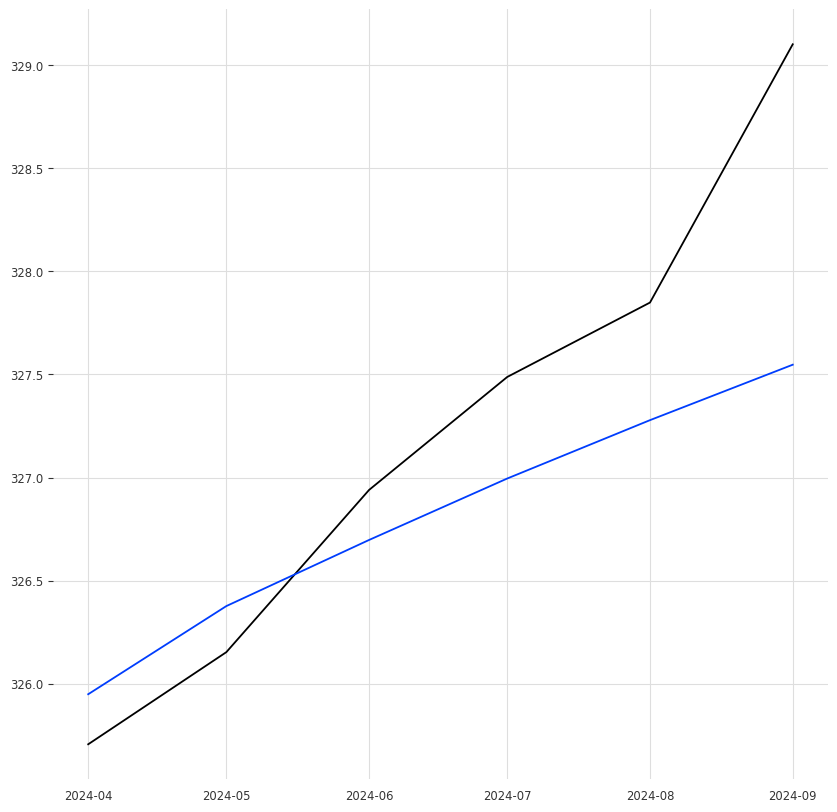

In [24]:
y_predicted = results.predict(start='04-01-2024', end='09-01-2024')
plt.figure(figsize=(10,10))
plt.plot(ARIMA_y_test)
plt.plot(y_predicted)
plt.savefig(os.path.join(plot_folder, 'ARIMA_prediction.png'))
plt.show()

/tmp/ipykernel_28403/4003770003.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/tmp/ipykernel_28403/4003770003.py:6: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



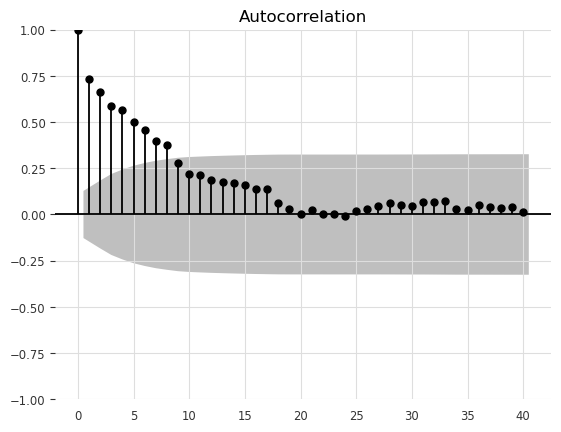

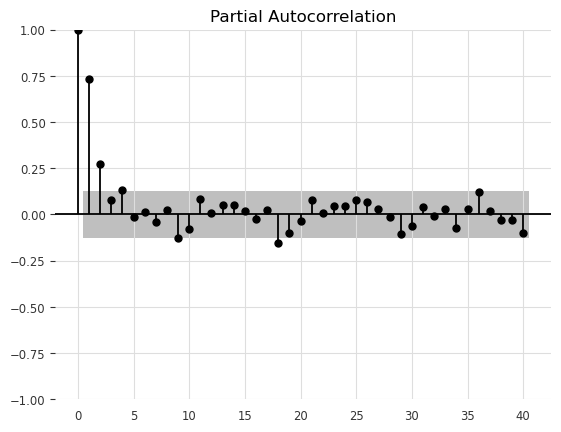

In [20]:
acf = plot_acf(diff_y, lags=40)
acf.savefig(os.path.join(plot_folder, 'ACF.png'))
acf.show()
pacf = plot_pacf(diff_y, lags=40)
pacf.savefig(os.path.join(plot_folder, 'PACF.png'))
pacf.show()

So MA term should be 9 and AR term should be 5

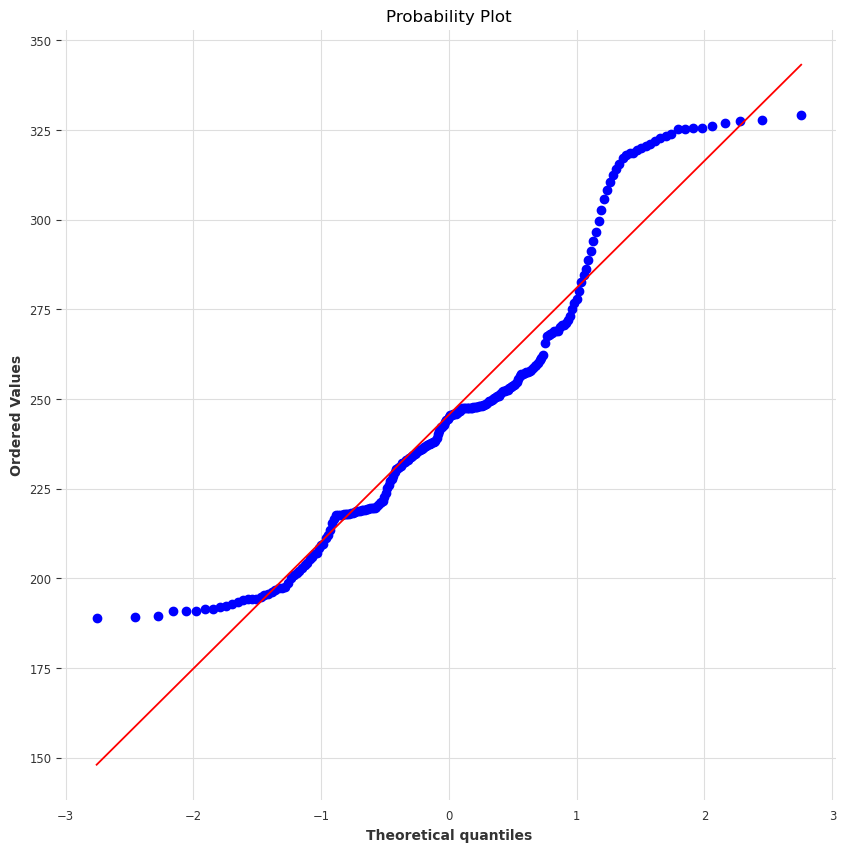

In [37]:
from scipy.stats import probplot


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
probplot(Y, plot=ax, dist='norm')
plt.savefig(os.path.join(plot_folder, 'QQ_plot_of_CPI.png'))
# scaler = StandardScaler()


# standard_Y

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.30801D-01    |proj g|=  2.33210D+00

At iterate    5    f=  7.90777D-01    |proj g|=  5.94123D-01


 This problem is unconstrained.



At iterate   10    f=  7.43301D-01    |proj g|=  3.32461D-01

At iterate   15    f=  7.39860D-01    |proj g|=  3.56429D-01

At iterate   20    f=  7.29045D-01    |proj g|=  3.49015D-01

At iterate   25    f=  7.19996D-01    |proj g|=  9.38969D-01

At iterate   30    f=  7.06485D-01    |proj g|=  4.54725D-01

At iterate   35    f=  6.99592D-01    |proj g|=  2.05390D-01

At iterate   40    f=  6.82817D-01    |proj g|=  1.09434D+00

At iterate   45    f=  6.47647D-01    |proj g|=  7.98125D-01


/Users/eddie/miniconda3/envs/cs163/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  6.38888D-01    |proj g|=  1.74155D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     58      1     0     0   1.742D-01   6.389D-01
  F =  0.63888794514477809     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                      
Dep. Variable:     Food and Beverages CPI (target)   No. Observations:                  231
Model:             SARIMAX(1, 1, 3)x(0, 1, [1], 9)   Log Likelihood                -147.583
Date:                             Sun, 03 Nov 2024   AIC                            3

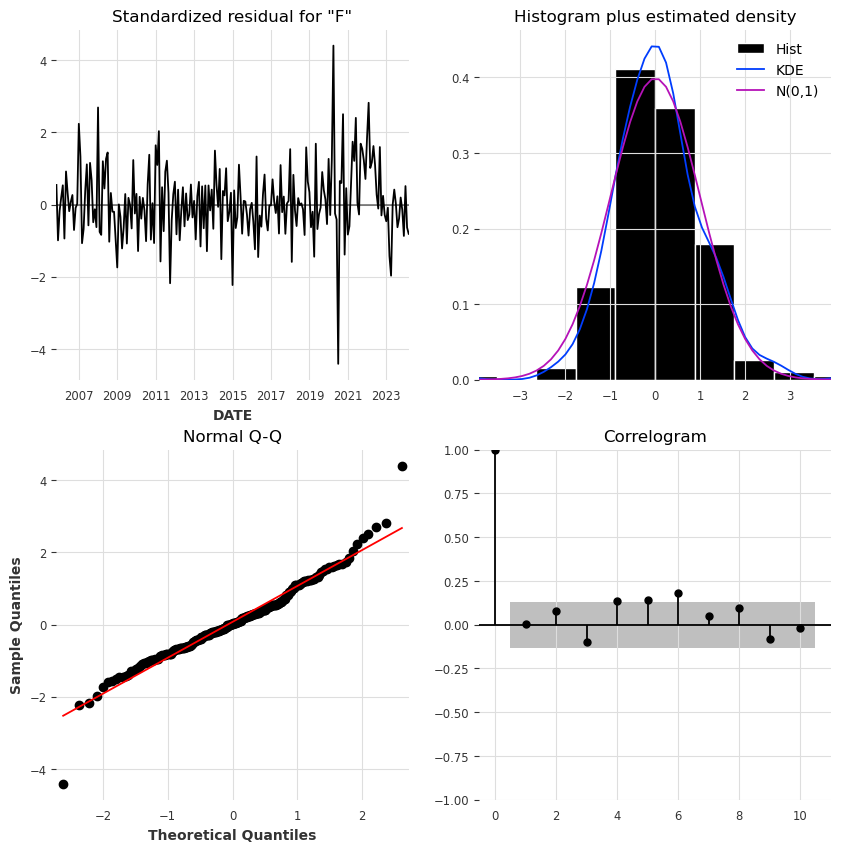

In [25]:
SARIMAX_X_train = X.iloc[:-6,:]
SARIMAX_y_train = Y.iloc[:-6]
SARIMAX_X_test = X.iloc[-6:,:]
SARIMAX_y_test = Y.iloc[-6:]

model = SARIMAX(
    endog=SARIMAX_y_train, 
    exog=SARIMAX_X_train, 
    order=(1, 1, 3), #p,d,q order
    seasonal_order=(0, 1, 1, 9),
    
)
results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(10,10))
plt.savefig(os.path.join(plot_folder, 'SARIMAX_diagnosis.png'))
plt.show()

In [38]:
import scipy.stats as stats

stat, pvalues = stats.shapiro(results.resid)
print('Shapiro-Wilks test p-value: ', pvalues)

Shapiro-Wilks test p-value:  1.1522927508249625e-31


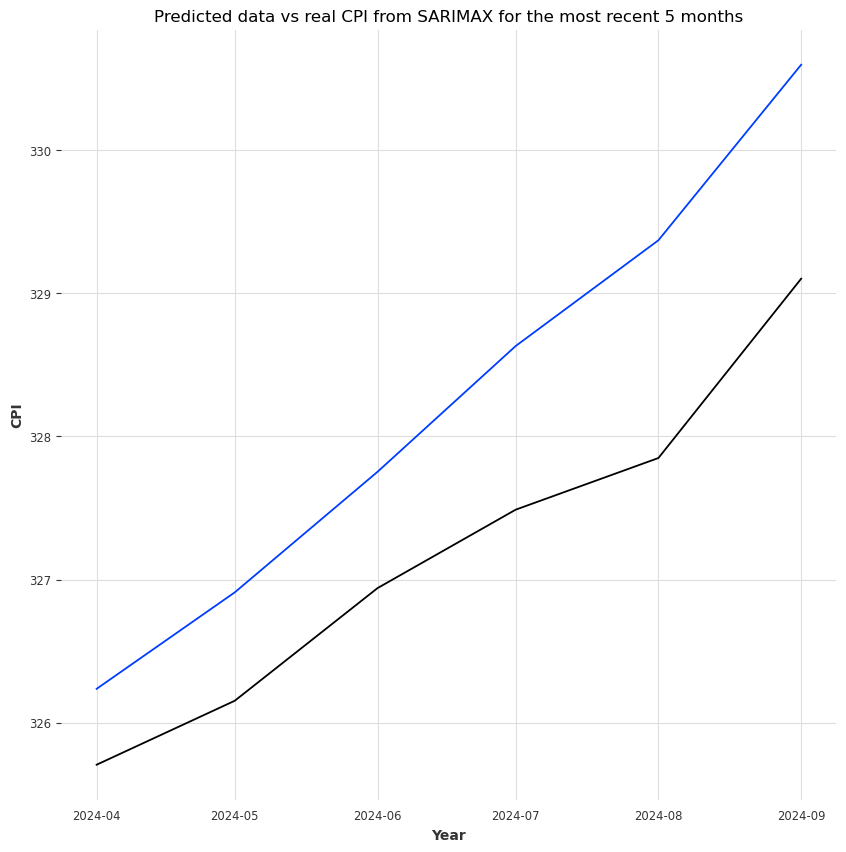

In [39]:
y_predicted = results.predict(exog= SARIMAX_X_test, start='04-01-2024', end='09-01-2024')
plt.figure(figsize=(10,10))
plt.plot(SARIMAX_y_test)
plt.plot(y_predicted)
plt.title('Predicted data vs real CPI from SARIMAX for the most recent 5 months')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.savefig(    
    os.path.join(plot_folder, 'SARIMAX_prediction.png')
)

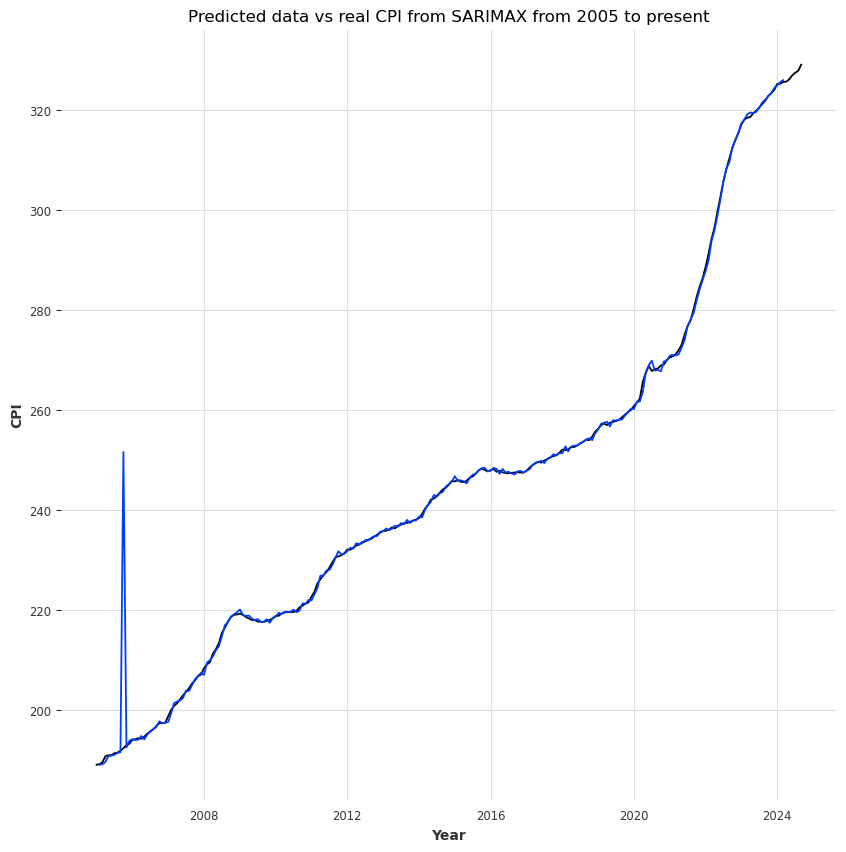

In [42]:
data_prediction = results.predict(exog=X, start='02-01-2005')
plt.figure(figsize=(10,10))
plt.plot(Y)
plt.plot(data_prediction)
plt.title('Predicted data vs real CPI from SARIMAX from 2005 to present')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.savefig(
    os.path.join(plot_folder, 'SARIMAX_prediction_whole_data.png')
)

### XGBoost 


In [67]:
tscv = TimeSeriesSplit(n_splits=10)
diff_y = differencing(Y, 1)

split_index = int(df.shape[0]*0.8)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = diff_y[:split_index]
y_test = diff_y[split_index:]


# param_grid = {
#     'n_estimators': [100, 200, 400],     # Number of trees
#     'max_depth': [3, 6, 8],              # Maximum depth of each tree
#     'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage
#     'subsample': [0.8, 1.0],             # Fraction of samples for training each tree
#     'colsample_bytree': [0.8, 1.0],      # Fraction of features for each tree,
# }

param_grid = {
    'n_estimators': [100, 200, 400],     # Number of trees
    'max_depth': [3, 6, 8],              # Maximum depth of each tree
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage
    'subsample': [0.8, 1.0],             # Fraction of samples for training each tree
    'colsample_bytree': [0.8, 1.0],      # Fraction of features for each tree,
}

# Define the model
model = XGBRegressor()

# Define MSE as the scoring metric
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Set up GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring={'MSE': mse_scorer, 'MAE': mae_scorer},
    cv=tscv,
    n_jobs=-1,        # Use all available cores
    verbose=1,
    refit='MSE',
)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

split_mse_cols = [col for col in results.columns if 'split' in col and 'MSE' in col]
split_mae_cols = [col for col in results.columns if 'split' in col and 'MAE' in col]

best_index = results[results.rank_test_MSE == 1].index
mse_changes = -np.ravel(results.loc[best_index, split_mse_cols].values)
mae_changes = -np.ravel(results.loc[best_index, split_mae_cols].values)

print("Average MSE across folds:", np.mean(mse_changes))
print("Average MAE across folds:", np.mean(mae_changes))

test_mse = mean_squared_error(y_test, best_model.predict(X_test))
test_mae = mean_absolute_error(y_test, best_model.predict(X_test))
print("Test MSE: ", test_mse)
print("Test MAE: ", test_mse)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Average MSE across folds: 0.2551261543996104
Average MAE across folds: 0.36038996090047604
Test MSE:  0.8915269768752841
Test MAE:  0.8915269768752841


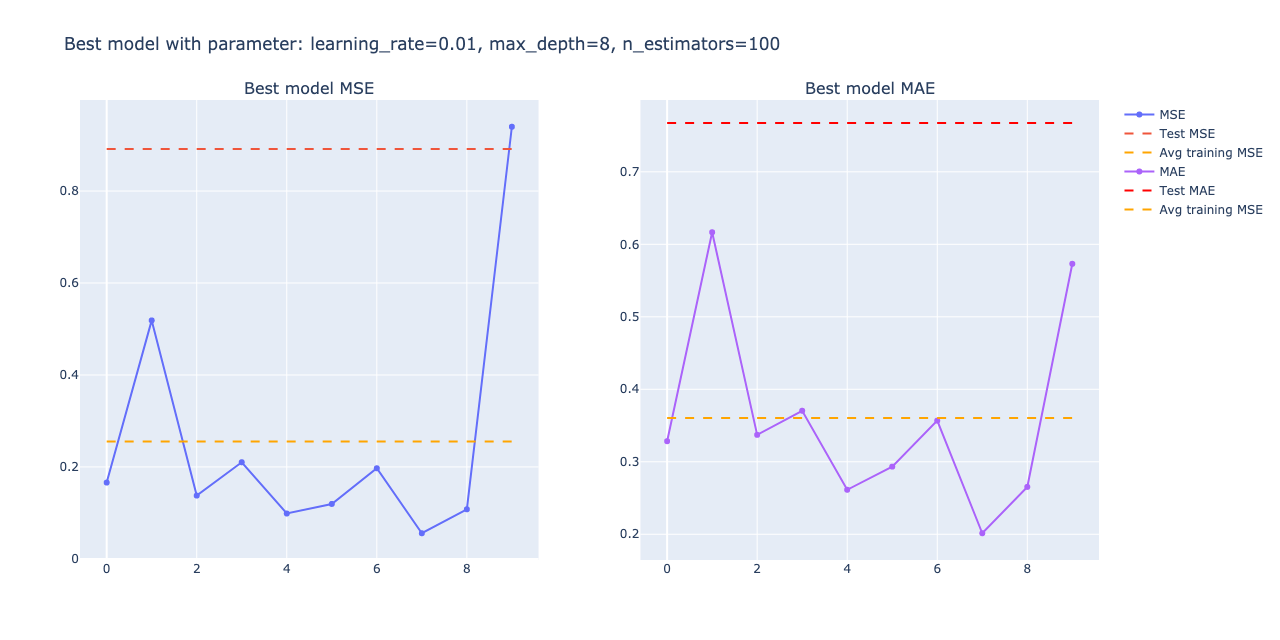

In [72]:
fig = make_subplots(1, 2, subplot_titles=["Best model MSE", "Best model MAE"])

fig.add_trace(
    go.Scatter(y=mse_changes, name='MSE'),
              row=1, 
              col=1)

fig.add_trace(
    go.Scatter(x=[0, len(mse_changes)-1], y=[test_mse, test_mse], name='Test MSE', mode='lines', line=dict(dash='dash')),
    row=1, 
    col=1
)

fig.add_trace(
    go.Scatter(x=[0, len(mse_changes)-1], y=[np.mean(mse_changes), np.mean(mse_changes)], name='Avg training MSE', mode='lines', line=dict(dash='dash', color='orange')),
    row=1, 
    col=1
)


fig.add_trace(
    go.Scatter(y=mae_changes, name='MAE'), 
              row=1, 
              col=2)

fig.add_trace(
    go.Scatter(x=[0, len(mae_changes)-1], y=[test_mae, test_mae], name='Test MAE', mode='lines', line=dict(dash='dash', color='red')),
    row=1, 
    col=2
)

fig.add_trace(
    go.Scatter(x=[0, len(mae_changes)-1], y=[np.mean(mae_changes), np.mean(mae_changes)], name='Avg training MSE', mode='lines', line=dict(dash='dash', color='orange')),
    row=1, 
    col=2
)

fig.update_layout(
    width=1280, 
    height=640, 
    title='Best model with parameter: ' + 
          # f"learning_rate={best_params['learning_rate']}, 
          f"learning_rate={best_params['learning_rate']}, "
          f"max_depth={best_params['max_depth']}, "
          f"n_estimators={best_params['n_estimators']}",
)
fig.write_image(os.path.join(plot_folder, 'MSE_and_MAE_of_best_XGBoost_model.png'))
fig.show()

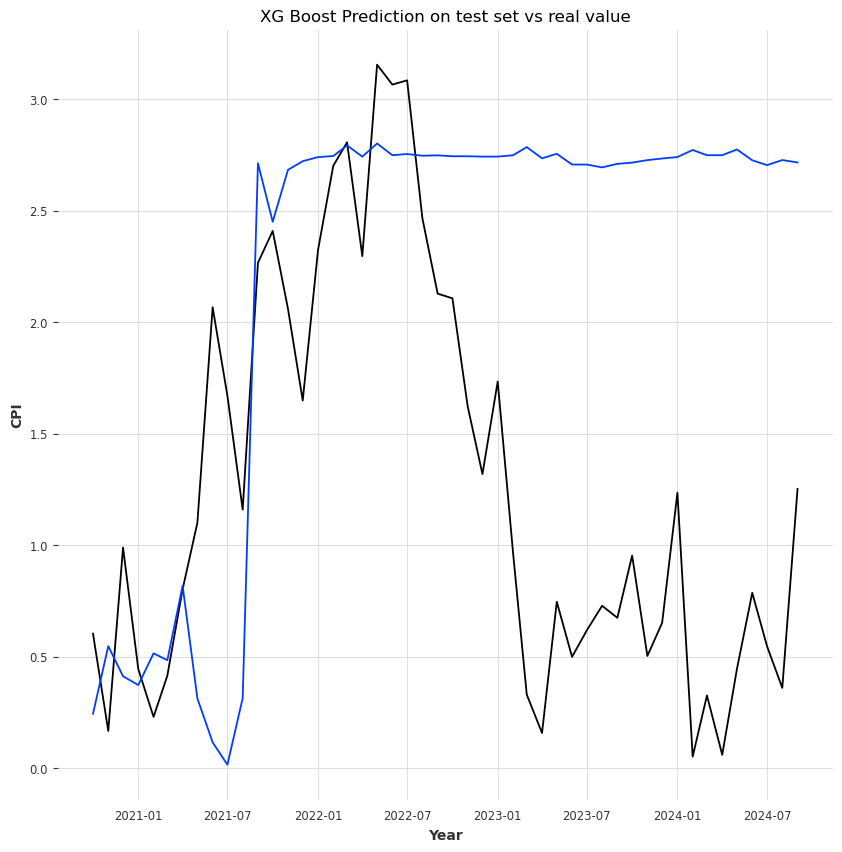

In [74]:
xg_boost_model = model.fit(X_train, y_train)
y_predicted = xg_boost_model.predict(X_test)

y_predicted = pd.Series(data=y_predicted, index=y_test.index)

plt.figure(figsize=(10,10))
plt.plot(y_test)
plt.plot(y_predicted)
plt.title('XG Boost Prediction on test set vs real value')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.savefig(os.path.join(plot_folder, 'XG_Boost_prediction'))
# y_test

Max difference 2.9802322e-07


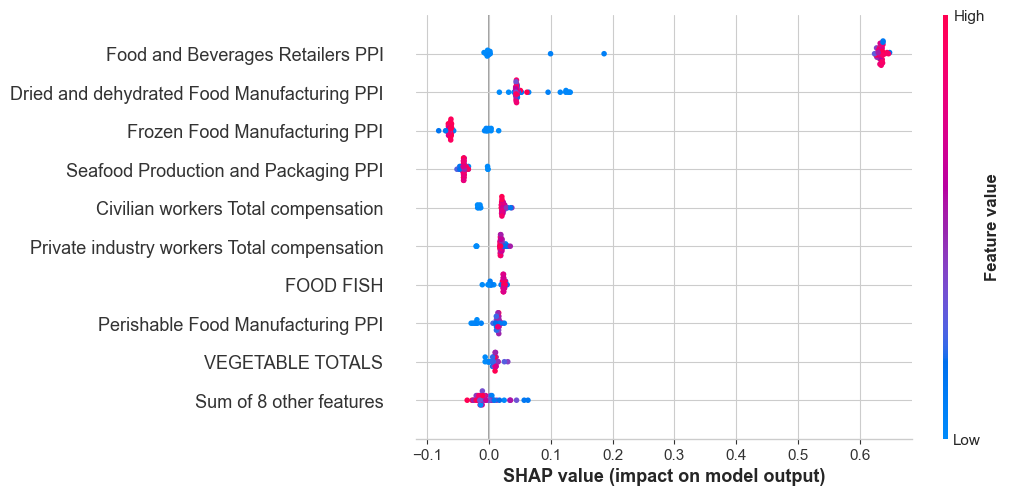

In [100]:
explainer = shap.TreeExplainer(best_model)
explanation = explainer(X_test)

y_predicted = best_model.predict(X_test)

shap_values = explanation.values
print("Max difference", np.abs(shap_values.sum(axis=1) + explanation.base_values - y_predicted).max())

fig = plt.figure(figsize=(10, len(X_test.columns) * 0.2)) 
shap.plots.beeswarm(explanation, show=False)
plt.savefig(os.path.join(plot_folder, 'SHAP_plot.png'), bbox_inches='tight')

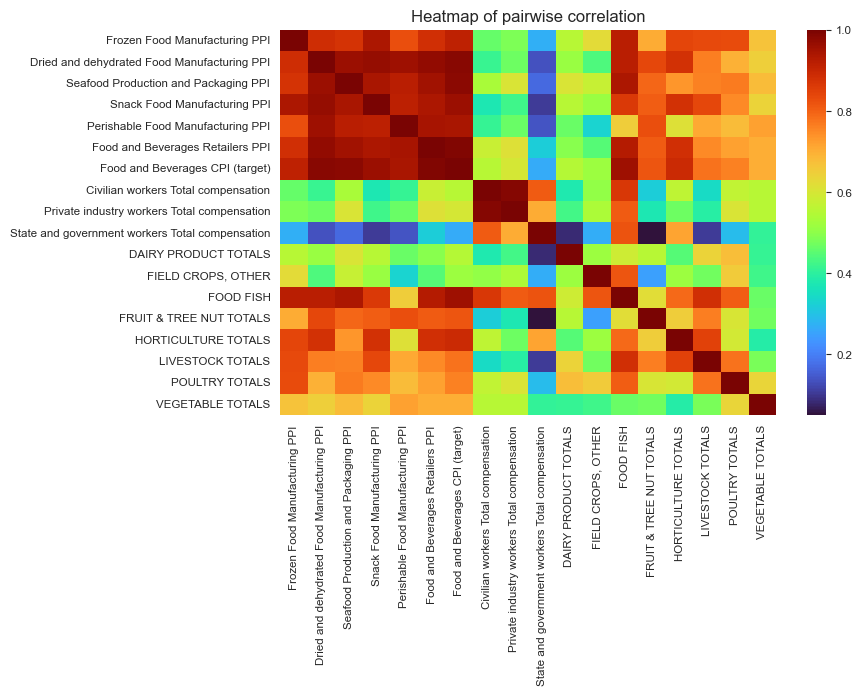

In [99]:
corr = df.corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr, cmap='turbo')
plt.title('Heatmap of pairwise correlation')
plt.savefig(os.path.join(plot_folder, 'Corr_heatmap.png'), bbox_inches='tight')

### LSTM Approach

In [ ]:
import datetime as dt

X_tmp = X.reset_index()

# X_tmp["Year"] = X_tmp['DATE'].apply(lambda x: x.dt.year)
X_tmp['DATE'] = pd.to_datetime(X_tmp['DATE'], errors='coerce')
X_tmp['Year'] = X_tmp['DATE'].dt.year
X_tmp['Month'] = X_tmp['DATE'].dt.month
X_tmp.drop(columns=['DATE'], inplace=True)
scaler = MinMaxScaler()

def create_sequences(data, target, seq_length):
    data_scaled = scaler.fit_transform(data)
    # target = scaler.fit_transform(target)
    X = []
    y = []
    
    for i in range(len(data_scaled) - seq_length):
        # Collect sequences across all features (except target) for each time step
        X.append(data_scaled[i:i+seq_length, :-1]) # All columns except the last one for X
        y.append(target[i+seq_length]) # Target value from the last column at each sequence end
    
    return np.array(X), np.array(y)

sequenced_X, sequenced_y = create_sequences(X_tmp, Y, 24) 


# sequenced_X = scaler.fit_transform(sequenced_X)
# for dim in sequenced_X:
#     sequenced_X[dim] = scaler.fit_transform(sequenced_X[dim])
sequenced_X.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sequenced_X, sequenced_y, test_size=0.2, random_state=42, shuffle=False)

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=24, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    
    # tf.keras.layers.LSTM(units=64, .return_sequences=False),
    
    # tf.keras.layers.LSTM(units=32, return_sequences=False),

    
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(1) 
])


model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=200)

y_predicted = model.predict(X_test)

mse = mean_squared_error(y_test, y_predicted)
mae = mean_absolute_error(y_test, y_predicted)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_predicted)

# Display additional results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()